In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns

import pandas as pd
import numpy as np
import math

from tensorflow.keras.models import load_model

import mdn
import joblib

from sklearn.model_selection import train_test_split

import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = 12

# MRFe/(Mg+Si)k2 prediction

In [251]:
input_parameters = [
    'Mass', 
    'Radius',
    'Fe/(Mg+Si)',
    'k_2',
]

output_parameters = [
    'H2O_radial_frac',
    'Mantle_radial_frac',
    'Core_radial_frac',
    'Core_mass_frac',
    'P_CMB', 
    'T_CMB',
]
# load trained model and scaler
OUTPUT_DIMS = len(output_parameters)
N_MIXES = 20
model = load_model(
    "MDN_MRFe(Mg+Si)k2_20220917.h5", 
    custom_objects={"MDN": mdn.MDN(OUTPUT_DIMS, N_MIXES), "mdn_loss_func": mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES)},
    compile=False
)
input_scaler = joblib.load("MDN_MRFe(Mg+Si)k2_Xscaler_20220917.save")
output_scaler = joblib.load("MDN_MRFe(Mg+Si)k2_yscaler_20220917.save")


In [252]:
df_all = pd.read_csv('Rocky_compostion.txt', sep='\t')
X = df_all[input_parameters]
y = df_all.loc[:, output_parameters]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
a, X_test_pre, b, y_test_pre = train_test_split(X_test, y_test, test_size=0.2)

## Predict Kepler-78b

### MDN model

In [253]:
# input mass and radius for predicting must be earth units
input_array = np.array(
    [
        [1.77],  # mass
        [1.228],  # radius
        [0.685],  # bulk Fe/(Mg+Si)
        [0.819],  # k2
    ]
)
scaled_input = input_scaler.transform(input_array.T)

In [254]:
pred = model.predict(scaled_input)
# # pred contains parameters for distributions, not actual points on the graph.
# print(pred)
# print(pred.shape)

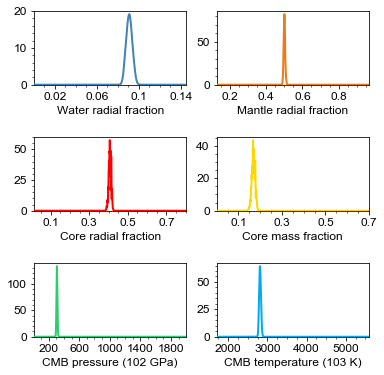

In [263]:
# split up the mixture parameters
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)

for m in range(OUTPUT_DIMS):
    locals()['mus'+str(m)] = []
    locals()['sigs'+str(m)] = []
#     print(m)
    for n in range(20):
#         print(n)
        locals()['mus'+str(m)].append(mus[0][n*OUTPUT_DIMS + m])
        locals()['sigs'+str(m)].append(sigs[0][n*OUTPUT_DIMS + m])

y_min1 = min(y_test_pre[output_parameters[0]])
y_max1 = max(y_test_pre[output_parameters[0]])
y_min2 = min(y_test_pre[output_parameters[1]])
y_max2 = max(y_test_pre[output_parameters[1]])
y_min3 = min(y_test_pre[output_parameters[2]])
y_max3 = max(y_test_pre[output_parameters[2]])
y_min4 = min(y_test_pre[output_parameters[3]])
y_max4 = max(y_test_pre[output_parameters[3]])
y_min5 = min(y_test_pre[output_parameters[4]])
y_max5 = max(y_test_pre[output_parameters[4]])
y_min6 = min(y_test_pre[output_parameters[5]])
y_max6 = max(y_test_pre[output_parameters[5]])

x_max = [
    1,
    1,
    1,
    1,
    1,
    1,
]
x_maxlabels = [
    y_min1+(y_max1-y_min1)*x_max[0],
    y_min2+(y_max2-y_min2)*x_max[1],
    y_min3+(y_max3-y_min3)*x_max[2],
    y_min4+(y_max4-y_min4)*x_max[3],
    y_min5+(y_max5-y_min5)*x_max[4],
    y_min6+(y_max6-y_min6)*x_max[5],
]

wrf = []  # H2O_radial_frac
mrf = []  # Mantle_radial_frac
crf = []  # Core_radial_frac
cmf = []  # Core mass frac
pcmb = []  # CMB temperature
tcmb = []  # CMB pressure


for x1 in np.arange(0.02,0.15,0.04):
    wrf.append((x1-y_min1)/(x_maxlabels[0]-y_min1)*x_max[0])
for x2 in np.arange(0.2,1,0.2):
    mrf.append((x2-y_min2)/(x_maxlabels[1]-y_min2)*x_max[1])
for x3 in np.arange(0.1,0.9,0.2):
    crf.append((x3-y_min3)/(x_maxlabels[2]-y_min3)*x_max[2])
for x4 in np.arange(0.1,0.8,0.2):
    cmf.append((x4-y_min4)/(x_maxlabels[3]-y_min4)*x_max[3])
for x5 in np.arange(200, 2000, 400):
    pcmb.append((x5-y_min5)/(x_maxlabels[4]-y_min5)*x_max[4])
for x6 in np.arange(2000, 6000, 1000):
    tcmb.append((x6-y_min6)/(x_maxlabels[5]-y_min6)*x_max[5])
    
xticklabels = [[round(x,2) for x in np.arange(0.02,0.15,0.04)],
               [round(x,2) for x in np.arange(0.2,1,0.2)],
               [round(x,2) for x in np.arange(0.1,0.9,0.2)],
               [round(x,2) for x in np.arange(0.1,0.8,0.2)],
               [round(x,2) for x in np.arange(200, 2000, 400)],
               [round(x,2) for x in np.arange(2000, 6000, 1000)],
              ]
xticks = [wrf, mrf, crf, cmf, pcmb, tcmb]

colors = [
    "steelblue",
    "#EA7D1A",
    "red", 
    "gold", 
    "#2ecc71",
    "#03a9f4"
]
predict_label = [
    "Water radial fraction", 
    "Mantle radial fraction",
    "Core radial fraction", 
    "Core mass fraction", 
    "CMB pressure (102 GPa)", 
    "CMB temperature (103 K)"
]


y_label = np.arange(0,1,0.001).reshape(-1,1)
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.7, wspace=0.2)
for i in range(OUTPUT_DIMS):
    ax = fig.add_subplot(3, 2, i+1)
    # y_label = y_labels[:, i].reshape(-1,1)
    # for i, label in zip(range(OUTPUT_DIMS), predict_label):
#     fig, ax = plt.subplots(figsize=(8,4))
    # label = "Water radial fraction"
    ###################Earth###########################
    mus_ = np.array(locals()['mus'+str(i)])
    sigs_ = np.array(locals()['sigs'+str(i)])
    factors = 1 / math.sqrt(2*math.pi) / sigs_
    exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
    GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
    plt.plot(
        y_label, 
        GMM_PDF,
        color=colors[i],
#         label=label,
        lw=2,
        zorder=10,
    )
    ax.set_xlim(0, x_max[i])
    ax.set_ylim(bottom=0)
    
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
#     print(xticks[i])
#     xticklabels[i]
    ax.set_xticks(xticks[i])
    ax.set_xticklabels(xticklabels[i])
    ax.set_xlabel(predict_label[i])
#     ax.set_ylabel("Probability density")
# plt.tight_layout()
plt.savefig('MRCk2_mdn_pred_Kepler-78b_20220925.pdf')

### Physical model

In [260]:
df_k = pd.read_csv('Kepler 78b.txt', sep='\t')
df_k.drop(columns=df_k.columns[0], inplace=True)  # delete useless column 0


0.14518
0.9656605
0.802923
0.699997
1999.49
5588.17


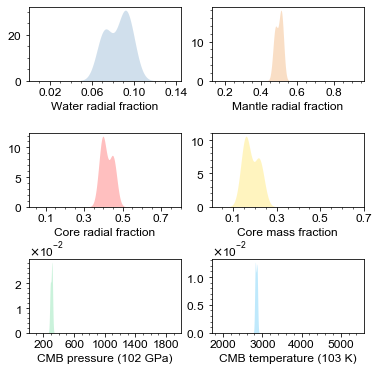

In [262]:
df_k1 = df_k[df_k['sigma_MRCk2']<=0.02]

inputs = ['Mass Earth_mass', 'Radius Earth_radius', 'Fe/(Si+Mg)', 'static Love number k2']
outputs = ['water radial frac', 'mantle radial frac', 'core radial frac', 'core mass frac', 'CMB press (GPa)', 'CMB temp (K)']
y_min1 = min(y_test_pre[output_parameters[0]])
y_max1 = max(y_test_pre[output_parameters[0]])
y_min2 = min(y_test_pre[output_parameters[1]])
y_max2 = max(y_test_pre[output_parameters[1]])
y_min3 = min(y_test_pre[output_parameters[2]])
y_max3 = max(y_test_pre[output_parameters[2]])
y_min4 = min(y_test_pre[output_parameters[3]])
y_max4 = max(y_test_pre[output_parameters[3]])
y_min5 = min(y_test_pre[output_parameters[4]])
y_max5 = max(y_test_pre[output_parameters[4]])
y_min6 = min(y_test_pre[output_parameters[5]])
y_max6 = max(y_test_pre[output_parameters[5]])

x_max = [
    1,
    1,
    1,
    1,
    1,
    1,
]
x_maxlabels = [
    y_min1+(y_max1-y_min1)*x_max[0],
    y_min2+(y_max2-y_min2)*x_max[1],
    y_min3+(y_max3-y_min3)*x_max[2],
    y_min4+(y_max4-y_min4)*x_max[3],
    y_min5+(y_max5-y_min5)*x_max[4],
    y_min6+(y_max6-y_min6)*x_max[5],
]

wrf = []  # H2O_radial_frac
mrf = []  # Mantle_radial_frac
crf = []  # Core_radial_frac
cmf = []  # Core mass frac
pcmb = []  # CMB temperature
tcmb = []  # CMB pressure


for x1 in np.arange(0.02,0.15,0.04):
    wrf.append((x1-y_min1)/(x_maxlabels[0]-y_min1)*x_max[0])
for x2 in np.arange(0.2,1,0.2):
    mrf.append((x2-y_min2)/(x_maxlabels[1]-y_min2)*x_max[1])
for x3 in np.arange(0.1,0.9,0.2):
    crf.append((x3-y_min3)/(x_maxlabels[2]-y_min3)*x_max[2])
for x4 in np.arange(0.1,0.8,0.2):
    cmf.append((x4-y_min4)/(x_maxlabels[3]-y_min4)*x_max[3])
for x5 in np.arange(200, 2000, 400):
    pcmb.append((x5-y_min5)/(x_maxlabels[4]-y_min5)*x_max[4])
for x6 in np.arange(2000, 6000, 1000):
    tcmb.append((x6-y_min6)/(x_maxlabels[5]-y_min6)*x_max[5])
    
xticklabels = [[round(x,2) for x in np.arange(0.02,0.15,0.04)],
               [round(x,2) for x in np.arange(0.2,1,0.2)],
               [round(x,2) for x in np.arange(0.1,0.9,0.2)],
               [round(x,2) for x in np.arange(0.1,0.8,0.2)],
               [round(x,2) for x in np.arange(200, 2000, 400)],
               [round(x,2) for x in np.arange(2000, 6000, 1000)],
              ]
xticks = [wrf, mrf, crf, cmf, pcmb, tcmb]
fig = plt.figure(figsize=(6,6))

fig.subplots_adjust(hspace=0.7, wspace=0.2)

x_max = [
    y_min1+(y_max1-y_min1)*1,
    y_min2+(y_max2-y_min2)*1,
    y_min3+(y_max3-y_min3)*1,
    y_min4+(y_max4-y_min4)*1,
    y_min5+(y_max5-y_min5)*1,
    y_min6+(y_max6-y_min6)*1,
]
for f in range(0,6):
    ax = fig.add_subplot(3, 2, f+1)
    y_min = locals()['y_min'+str(f+1)]
    y_max = locals()['y_max'+str(f+1)]
    print(y_max)
    sns.kdeplot(df_k1[outputs[f]], color=colors[f],fill=True,linewidth=0,bw_adjust=1,)
    ax.set_xlim(y_min, y_max)
    ax.set_ylim(bottom=0)
    
#     print(xticks[i])
#     xticklabels[i]

    ax.set_xticks(xticklabels[f])
#     ax.set_xticklabels(xticklabels[f])
    ax.set_xlabel(predict_label[f])
    ax.set_ylabel(None)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    formatter = tck.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-2,2))
    ax.yaxis.set_major_formatter(formatter)
# plt.tight_layout()
plt.savefig('MRCk2_phy_pred_Kepler-78b_20220925.pdf')

## Predict HD3167b

### MDN model

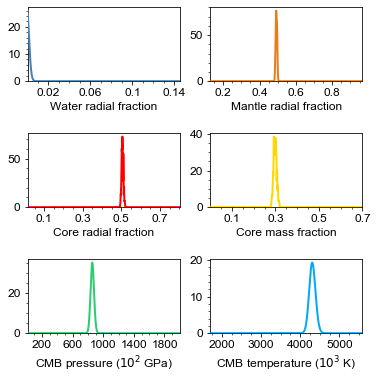

In [265]:
# input mass and radius for predicting must be earth units
input_array2 = np.array(
    [
        [5.69],  # mass
        [1.574],  # radius
        [0.630],  # bulk Fe/(Mg+Si)
        [0.854],  # k2
    ]
)
scaled_input2 = input_scaler.transform(input_array2.T)

pred2 = model.predict(scaled_input2)


# split up the mixture parameters
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred2)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred2)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred2)

for m in range(OUTPUT_DIMS):
    locals()['mus'+str(m)] = []
    locals()['sigs'+str(m)] = []
#     print(m)
    for n in range(20):
#         print(n)
        locals()['mus'+str(m)].append(mus[0][n*OUTPUT_DIMS + m])
        locals()['sigs'+str(m)].append(sigs[0][n*OUTPUT_DIMS + m])

y_min1 = min(y_test_pre[output_parameters[0]])
y_max1 = max(y_test_pre[output_parameters[0]])
y_min2 = min(y_test_pre[output_parameters[1]])
y_max2 = max(y_test_pre[output_parameters[1]])
y_min3 = min(y_test_pre[output_parameters[2]])
y_max3 = max(y_test_pre[output_parameters[2]])
y_min4 = min(y_test_pre[output_parameters[3]])
y_max4 = max(y_test_pre[output_parameters[3]])
y_min5 = min(y_test_pre[output_parameters[4]])
y_max5 = max(y_test_pre[output_parameters[4]])
y_min6 = min(y_test_pre[output_parameters[5]])
y_max6 = max(y_test_pre[output_parameters[5]])

x_max = [
    1,
    1,
    1,
    1,
    1,
    1,
]
x_maxlabels = [
    y_min1+(y_max1-y_min1)*x_max[0],
    y_min2+(y_max2-y_min2)*x_max[1],
    y_min3+(y_max3-y_min3)*x_max[2],
    y_min4+(y_max4-y_min4)*x_max[3],
    y_min5+(y_max5-y_min5)*x_max[4],
    y_min6+(y_max6-y_min6)*x_max[5],
]

wrf = []  # H2O_radial_frac
mrf = []  # Mantle_radial_frac
crf = []  # Core_radial_frac
cmf = []  # Core mass frac
pcmb = []  # CMB temperature
tcmb = []  # CMB pressure


for x1 in np.arange(0.02,0.15,0.04):
    wrf.append((x1-y_min1)/(x_maxlabels[0]-y_min1)*x_max[0])
for x2 in np.arange(0.2,1,0.2):
    mrf.append((x2-y_min2)/(x_maxlabels[1]-y_min2)*x_max[1])
for x3 in np.arange(0.1,0.9,0.2):
    crf.append((x3-y_min3)/(x_maxlabels[2]-y_min3)*x_max[2])
for x4 in np.arange(0.1,0.8,0.2):
    cmf.append((x4-y_min4)/(x_maxlabels[3]-y_min4)*x_max[3])
for x5 in np.arange(200, 2000, 400):
    pcmb.append((x5-y_min5)/(x_maxlabels[4]-y_min5)*x_max[4])
for x6 in np.arange(2000, 6000, 1000):
    tcmb.append((x6-y_min6)/(x_maxlabels[5]-y_min6)*x_max[5])
    
xticklabels = [[round(x,2) for x in np.arange(0.02,0.15,0.04)],
               [round(x,2) for x in np.arange(0.2,1,0.2)],
               [round(x,2) for x in np.arange(0.1,0.9,0.2)],
               [round(x,2) for x in np.arange(0.1,0.8,0.2)],
               [round(x,2) for x in np.arange(200, 2000, 400)],
               [round(x,2) for x in np.arange(2000, 6000, 1000)],
              ]
xticks = [wrf, mrf, crf, cmf, pcmb, tcmb]

colors = [
    "steelblue",
    "#EA7D1A",
    "red", 
    "gold", 
    "#2ecc71",
    "#03a9f4"
]
pred2ict_label = [
    "Water radial fraction", 
    "Mantle radial fraction",
    "Core radial fraction", 
    "Core mass fraction", 
    "CMB pressure ($10^2$ GPa)", 
    "CMB temperature ($10^3$ K)"
]


y_label = np.arange(0,1,0.001).reshape(-1,1)
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.7, wspace=0.2)
for i in range(OUTPUT_DIMS):
    ax = fig.add_subplot(3, 2, i+1)
    # y_label = y_labels[:, i].reshape(-1,1)
    # for i, label in zip(range(OUTPUT_DIMS), pred2ict_label):
#     fig, ax = plt.subplots(figsize=(8,4))
    # label = "Water radial fraction"
    ###################Earth###########################
    mus_ = np.array(locals()['mus'+str(i)])
    sigs_ = np.array(locals()['sigs'+str(i)])
    factors = 1 / math.sqrt(2*math.pi) / sigs_
    exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
    GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
    plt.plot(
        y_label, 
        GMM_PDF,
        color=colors[i],
#         label=label,
        lw=2,
        zorder=10,
    )
    ax.set_xlim(0, x_max[i])
    ax.set_ylim(bottom=0)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
#     print(xticks[i])
#     xticklabels[i]
    ax.set_xticks(xticks[i])
    ax.set_xticklabels(xticklabels[i])
    ax.set_xlabel(pred2ict_label[i])
    ax.set_ylabel(None)
# plt.tight_layout()
plt.savefig('MRCk2_mdn_pred_HD3167b_20220925.pdf')

### Physical model

In [266]:
df_h = pd.read_csv('HD3167b.txt', sep='\t')
df_h.drop(columns=df_h.columns[0], inplace=True)  # delete useless column 0

0.14518
0.9656605
0.802923
0.699997
1999.49
5588.17


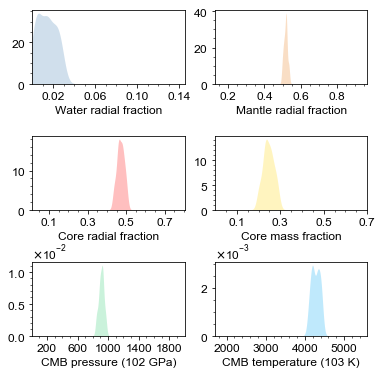

In [269]:
df_h1 = df_h[df_h['sigma_MRCk2']<=0.02]

inputs = ['Mass Earth_mass', 'Radius Earth_radius', 'Fe/(Si+Mg)', 'static Love number k2']
outputs = ['water radial frac', 'mantle radial frac', 'core radial frac', 'core mass frac', 'CMB press (GPa)', 'CMB temp (K)']
y_min1 = min(y_test_pre[output_parameters[0]])
y_max1 = max(y_test_pre[output_parameters[0]])
y_min2 = min(y_test_pre[output_parameters[1]])
y_max2 = max(y_test_pre[output_parameters[1]])
y_min3 = min(y_test_pre[output_parameters[2]])
y_max3 = max(y_test_pre[output_parameters[2]])
y_min4 = min(y_test_pre[output_parameters[3]])
y_max4 = max(y_test_pre[output_parameters[3]])
y_min5 = min(y_test_pre[output_parameters[4]])
y_max5 = max(y_test_pre[output_parameters[4]])
y_min6 = min(y_test_pre[output_parameters[5]])
y_max6 = max(y_test_pre[output_parameters[5]])

x_max = [
    1,
    1,
    1,
    1,
    1,
    1,
]
x_maxlabels = [
    y_min1+(y_max1-y_min1)*x_max[0],
    y_min2+(y_max2-y_min2)*x_max[1],
    y_min3+(y_max3-y_min3)*x_max[2],
    y_min4+(y_max4-y_min4)*x_max[3],
    y_min5+(y_max5-y_min5)*x_max[4],
    y_min6+(y_max6-y_min6)*x_max[5],
]

wrf = []  # H2O_radial_frac
mrf = []  # Mantle_radial_frac
crf = []  # Core_radial_frac
cmf = []  # Core mass frac
pcmb = []  # CMB temperature
tcmb = []  # CMB pressure


for x1 in np.arange(0.02,0.15,0.04):
    wrf.append((x1-y_min1)/(x_maxlabels[0]-y_min1)*x_max[0])
for x2 in np.arange(0.2,1,0.2):
    mrf.append((x2-y_min2)/(x_maxlabels[1]-y_min2)*x_max[1])
for x3 in np.arange(0.1,0.9,0.2):
    crf.append((x3-y_min3)/(x_maxlabels[2]-y_min3)*x_max[2])
for x4 in np.arange(0.1,0.8,0.2):
    cmf.append((x4-y_min4)/(x_maxlabels[3]-y_min4)*x_max[3])
for x5 in np.arange(200, 2000, 400):
    pcmb.append((x5-y_min5)/(x_maxlabels[4]-y_min5)*x_max[4])
for x6 in np.arange(2000, 6000, 1000):
    tcmb.append((x6-y_min6)/(x_maxlabels[5]-y_min6)*x_max[5])
    
xticklabels = [[round(x,2) for x in np.arange(0.02,0.15,0.04)],
               [round(x,2) for x in np.arange(0.2,1,0.2)],
               [round(x,2) for x in np.arange(0.1,0.9,0.2)],
               [round(x,2) for x in np.arange(0.1,0.8,0.2)],
               [round(x,2) for x in np.arange(200, 2000, 400)],
               [round(x,2) for x in np.arange(2000, 6000, 1000)],
              ]
xticks = [wrf, mrf, crf, cmf, pcmb, tcmb]
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.7, wspace=0.2)



x_max = [
    y_min1+(y_max1-y_min1)*1,
    y_min2+(y_max2-y_min2)*1,
    y_min3+(y_max3-y_min3)*1,
    y_min4+(y_max4-y_min4)*1,
    y_min5+(y_max5-y_min5)*1,
    y_min6+(y_max6-y_min6)*1,
]
for f in range(0,6):
    ax = fig.add_subplot(3, 2, f+1)
    y_min = locals()['y_min'+str(f+1)]
    y_max = locals()['y_max'+str(f+1)]
    print(y_max)
    sns.kdeplot(df_h1[outputs[f]], color=colors[f],fill=True,linewidth=0,bw_adjust=0.7,)
    ax.set_xlim(y_min, y_max)
    ax.set_ylim(bottom=0)
    
#     print(xticks[i])
#     xticklabels[i]

    ax.set_xticks(xticklabels[f])
#     ax.set_xticklabels(xticklabels[f])
    ax.set_xlabel(predict_label[f])
    ax.set_ylabel(None)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    formatter = tck.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-2,2))
    ax.yaxis.set_major_formatter(formatter)
# plt.tight_layout()
plt.savefig('MRCk2_phy_pred_HD3167b_20220925.pdf')

# MRFe/(Mg+Si)

In [270]:
input_parameters = [
    'Mass', 
    'Radius',
    'Fe/(Mg+Si)',
]

output_parameters = [
    'H2O_radial_frac',
    'Mantle_radial_frac',
    'Core_radial_frac',
    'Core_mass_frac',
    'P_CMB', 
    'T_CMB',
]
# load trained model and scaler
OUTPUT_DIMS = len(output_parameters)
N_MIXES = 20
model = load_model(
    "MDN_MRFe(Mg+Si)_20220916.h5", 
    custom_objects={"MDN": mdn.MDN(OUTPUT_DIMS, N_MIXES), "mdn_loss_func": mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES)},
    compile=False
)
input_scaler = joblib.load("MDN_MRFe(Mg+Si)_Xscaler_20220916.save")
output_scaler = joblib.load("MDN_MRFe(Mg+Si)_yscaler_20220916.save")


In [271]:
df_all = pd.read_csv('Rocky_compostion.txt', sep='\t')
X = df_all[input_parameters]
y = df_all.loc[:, output_parameters]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
a, X_test_pre, b, y_test_pre = train_test_split(X_test, y_test, test_size=0.2)

## Predict Kepler-78b

### MDN model

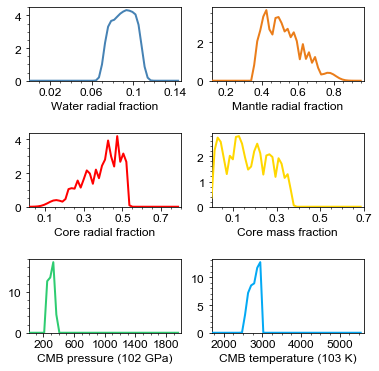

In [272]:
# input mass and radius for predicting must be earth units
input_array = np.array(
    [
        [1.77],  # mass
        [1.228],  # radius
        [0.685],  # bulk Fe/(Mg+Si)
#         [0.819],  # k2
    ]
)
scaled_input = input_scaler.transform(input_array.T)

pred = model.predict(scaled_input)

# split up the mixture parameters
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)

for m in range(OUTPUT_DIMS):
    locals()['mus'+str(m)] = []
    locals()['sigs'+str(m)] = []
#     print(m)
    for n in range(20):
#         print(n)
        locals()['mus'+str(m)].append(mus[0][n*OUTPUT_DIMS + m])
        locals()['sigs'+str(m)].append(sigs[0][n*OUTPUT_DIMS + m])

y_min1 = min(y_test_pre[output_parameters[0]])
y_max1 = max(y_test_pre[output_parameters[0]])
y_min2 = min(y_test_pre[output_parameters[1]])
y_max2 = max(y_test_pre[output_parameters[1]])
y_min3 = min(y_test_pre[output_parameters[2]])
y_max3 = max(y_test_pre[output_parameters[2]])
y_min4 = min(y_test_pre[output_parameters[3]])
y_max4 = max(y_test_pre[output_parameters[3]])
y_min5 = min(y_test_pre[output_parameters[4]])
y_max5 = max(y_test_pre[output_parameters[4]])
y_min6 = min(y_test_pre[output_parameters[5]])
y_max6 = max(y_test_pre[output_parameters[5]])

x_max = [
    1,
    1,
    1,
    1,
    1,
    1,
]
x_maxlabels = [
    y_min1+(y_max1-y_min1)*x_max[0],
    y_min2+(y_max2-y_min2)*x_max[1],
    y_min3+(y_max3-y_min3)*x_max[2],
    y_min4+(y_max4-y_min4)*x_max[3],
    y_min5+(y_max5-y_min5)*x_max[4],
    y_min6+(y_max6-y_min6)*x_max[5],
]

wrf = []  # H2O_radial_frac
mrf = []  # Mantle_radial_frac
crf = []  # Core_radial_frac
cmf = []  # Core mass frac
pcmb = []  # CMB temperature
tcmb = []  # CMB pressure


for x1 in np.arange(0.02,0.15,0.04):
    wrf.append((x1-y_min1)/(x_maxlabels[0]-y_min1)*x_max[0])
for x2 in np.arange(0.2,1,0.2):
    mrf.append((x2-y_min2)/(x_maxlabels[1]-y_min2)*x_max[1])
for x3 in np.arange(0.1,0.9,0.2):
    crf.append((x3-y_min3)/(x_maxlabels[2]-y_min3)*x_max[2])
for x4 in np.arange(0.1,0.8,0.2):
    cmf.append((x4-y_min4)/(x_maxlabels[3]-y_min4)*x_max[3])
for x5 in np.arange(200, 2000, 400):
    pcmb.append((x5-y_min5)/(x_maxlabels[4]-y_min5)*x_max[4])
for x6 in np.arange(2000, 6000, 1000):
    tcmb.append((x6-y_min6)/(x_maxlabels[5]-y_min6)*x_max[5])
    
xticklabels = [[round(x,2) for x in np.arange(0.02,0.15,0.04)],
               [round(x,2) for x in np.arange(0.2,1,0.2)],
               [round(x,2) for x in np.arange(0.1,0.9,0.2)],
               [round(x,2) for x in np.arange(0.1,0.8,0.2)],
               [round(x,2) for x in np.arange(200, 2000, 400)],
               [round(x,2) for x in np.arange(2000, 6000, 1000)],
              ]
xticks = [wrf, mrf, crf, cmf, pcmb, tcmb]

colors = [
    "steelblue",
    "#EA7D1A",
    "red", 
    "gold", 
    "#2ecc71",
    "#03a9f4"
]
predict_label = [
    "Water radial fraction", 
    "Mantle radial fraction",
    "Core radial fraction", 
    "Core mass fraction", 
    "CMB pressure (102 GPa)", 
    "CMB temperature (103 K)"
]


y_label = np.arange(0,1,0.02).reshape(-1,1)
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.7, wspace=0.2)
for i in range(OUTPUT_DIMS):
    ax = fig.add_subplot(3, 2, i+1)
    # y_label = y_labels[:, i].reshape(-1,1)
    # for i, label in zip(range(OUTPUT_DIMS), predict_label):
#     fig, ax = plt.subplots(figsize=(8,4))
    # label = "Water radial fraction"
    ###################Earth###########################
    mus_ = np.array(locals()['mus'+str(i)])
    sigs_ = np.array(locals()['sigs'+str(i)])
    factors = 1 / math.sqrt(2*math.pi) / sigs_
    exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
    GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
    plt.plot(
        y_label, 
        GMM_PDF,
        color=colors[i],
#         label=label,
        lw=2,
        zorder=10,
    )
    ax.set_xlim(0, x_max[i])
    ax.set_ylim(bottom=0)
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    formatter = tck.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-3,2))
    ax.yaxis.set_major_formatter(formatter)
#     print(xticks[i])
#     xticklabels[i]
    ax.set_xticks(xticks[i])
    ax.set_xticklabels(xticklabels[i])
    ax.set_xlabel(predict_label[i])
    ax.set_ylabel(None)
# plt.tight_layout()
plt.savefig('MRC_mdn_pred_Kepler-78b_20220925.pdf')

### Physical model

In [273]:
df_k = pd.read_csv('Kepler 78b.txt', sep='\t')
df_k.drop(columns=df_k.columns[0], inplace=True)  # delete useless column 0

0.145558
0.96292017
0.802597
0.699997
1999.49
5619.25


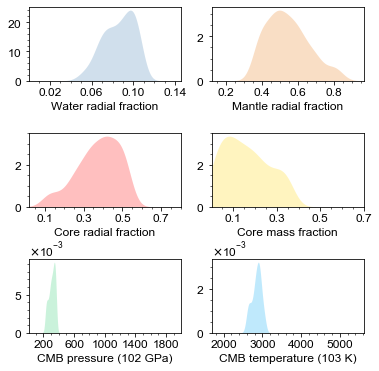

In [274]:
df_k1 = df_k[df_k['sigma_MRC']<=0.02]

inputs = ['Mass Earth_mass', 'Radius Earth_radius', 'Fe/(Si+Mg)', 'static Love number k2']
outputs = ['water radial frac', 'mantle radial frac', 'core radial frac', 'core mass frac', 'CMB press (GPa)', 'CMB temp (K)']
y_min1 = min(y_test_pre[output_parameters[0]])
y_max1 = max(y_test_pre[output_parameters[0]])
y_min2 = min(y_test_pre[output_parameters[1]])
y_max2 = max(y_test_pre[output_parameters[1]])
y_min3 = min(y_test_pre[output_parameters[2]])
y_max3 = max(y_test_pre[output_parameters[2]])
y_min4 = min(y_test_pre[output_parameters[3]])
y_max4 = max(y_test_pre[output_parameters[3]])
y_min5 = min(y_test_pre[output_parameters[4]])
y_max5 = max(y_test_pre[output_parameters[4]])
y_min6 = min(y_test_pre[output_parameters[5]])
y_max6 = max(y_test_pre[output_parameters[5]])

x_max = [
    1,
    1,
    1,
    1,
    1,
    1,
]
x_maxlabels = [
    y_min1+(y_max1-y_min1)*x_max[0],
    y_min2+(y_max2-y_min2)*x_max[1],
    y_min3+(y_max3-y_min3)*x_max[2],
    y_min4+(y_max4-y_min4)*x_max[3],
    y_min5+(y_max5-y_min5)*x_max[4],
    y_min6+(y_max6-y_min6)*x_max[5],
]

wrf = []  # H2O_radial_frac
mrf = []  # Mantle_radial_frac
crf = []  # Core_radial_frac
cmf = []  # Core mass frac
pcmb = []  # CMB temperature
tcmb = []  # CMB pressure


for x1 in np.arange(0.02,0.15,0.04):
    wrf.append((x1-y_min1)/(x_maxlabels[0]-y_min1)*x_max[0])
for x2 in np.arange(0.2,1,0.2):
    mrf.append((x2-y_min2)/(x_maxlabels[1]-y_min2)*x_max[1])
for x3 in np.arange(0.1,0.9,0.2):
    crf.append((x3-y_min3)/(x_maxlabels[2]-y_min3)*x_max[2])
for x4 in np.arange(0.1,0.8,0.2):
    cmf.append((x4-y_min4)/(x_maxlabels[3]-y_min4)*x_max[3])
for x5 in np.arange(200, 2000, 400):
    pcmb.append((x5-y_min5)/(x_maxlabels[4]-y_min5)*x_max[4])
for x6 in np.arange(2000, 6000, 1000):
    tcmb.append((x6-y_min6)/(x_maxlabels[5]-y_min6)*x_max[5])
    
xticklabels = [[round(x,2) for x in np.arange(0.02,0.15,0.04)],
               [round(x,2) for x in np.arange(0.2,1,0.2)],
               [round(x,2) for x in np.arange(0.1,0.9,0.2)],
               [round(x,2) for x in np.arange(0.1,0.8,0.2)],
               [round(x,2) for x in np.arange(200, 2000, 400)],
               [round(x,2) for x in np.arange(2000, 6000, 1000)],
              ]
xticks = [wrf, mrf, crf, cmf, pcmb, tcmb]
fig = plt.figure(figsize=(6,6))


fig.subplots_adjust(hspace=0.7, wspace=0.2)



x_max = [
    y_min1+(y_max1-y_min1)*1,
    y_min2+(y_max2-y_min2)*1,
    y_min3+(y_max3-y_min3)*1,
    y_min4+(y_max4-y_min4)*1,
    y_min5+(y_max5-y_min5)*1,
    y_min6+(y_max6-y_min6)*1,
]
for f in range(0,6):
    ax = fig.add_subplot(3, 2, f+1)
    y_min = locals()['y_min'+str(f+1)]
    y_max = locals()['y_max'+str(f+1)]
    print(y_max)
    sns.kdeplot(df_k1[outputs[f]], color=colors[f],fill=True,linewidth=0,bw_adjust=1,)
    ax.set_xlim(y_min, y_max)
    ax.set_ylim(bottom=0)
    
#     print(xticks[i])
#     xticklabels[i]

    ax.set_xticks(xticklabels[f])
#     ax.set_xticklabels(xticklabels[f])
    ax.set_xlabel(predict_label[f])
    ax.set_ylabel(None)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    formatter = tck.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-3,2))
    ax.yaxis.set_major_formatter(formatter)
#     ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
# plt.tight_layout()
plt.savefig('MRC_phy_pred_Kepler-78b_20220925.pdf')

## HD3167b

### MDN model

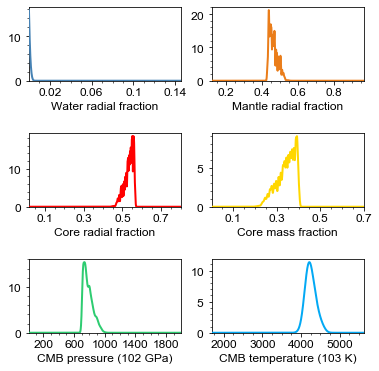

In [275]:
# input mass and radius for predicting must be earth units
input_array2 = np.array(
    [
        [5.69],  # mass
        [1.574],  # radius
        [0.630],  # bulk Fe/(Mg+Si)
#         [0.854],  # k2
    ]
)
scaled_input2 = input_scaler.transform(input_array2.T)

pred2 = model.predict(scaled_input2)


# split up the mixture parameters
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred2)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred2)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred2)

for m in range(OUTPUT_DIMS):
    locals()['mus'+str(m)] = []
    locals()['sigs'+str(m)] = []
#     print(m)
    for n in range(20):
#         print(n)
        locals()['mus'+str(m)].append(mus[0][n*OUTPUT_DIMS + m])
        locals()['sigs'+str(m)].append(sigs[0][n*OUTPUT_DIMS + m])

y_min1 = min(y_test_pre[output_parameters[0]])
y_max1 = max(y_test_pre[output_parameters[0]])
y_min2 = min(y_test_pre[output_parameters[1]])
y_max2 = max(y_test_pre[output_parameters[1]])
y_min3 = min(y_test_pre[output_parameters[2]])
y_max3 = max(y_test_pre[output_parameters[2]])
y_min4 = min(y_test_pre[output_parameters[3]])
y_max4 = max(y_test_pre[output_parameters[3]])
y_min5 = min(y_test_pre[output_parameters[4]])
y_max5 = max(y_test_pre[output_parameters[4]])
y_min6 = min(y_test_pre[output_parameters[5]])
y_max6 = max(y_test_pre[output_parameters[5]])

x_max = [
    1,
    1,
    1,
    1,
    1,
    1,
]
x_maxlabels = [
    y_min1+(y_max1-y_min1)*x_max[0],
    y_min2+(y_max2-y_min2)*x_max[1],
    y_min3+(y_max3-y_min3)*x_max[2],
    y_min4+(y_max4-y_min4)*x_max[3],
    y_min5+(y_max5-y_min5)*x_max[4],
    y_min6+(y_max6-y_min6)*x_max[5],
]

wrf = []  # H2O_radial_frac
mrf = []  # Mantle_radial_frac
crf = []  # Core_radial_frac
cmf = []  # Core mass frac
pcmb = []  # CMB temperature
tcmb = []  # CMB pressure

for x1 in np.arange(0.02,0.15,0.04):
    wrf.append((x1-y_min1)/(x_maxlabels[0]-y_min1)*x_max[0])
for x2 in np.arange(0.2,1,0.2):
    mrf.append((x2-y_min2)/(x_maxlabels[1]-y_min2)*x_max[1])
for x3 in np.arange(0.1,0.9,0.2):
    crf.append((x3-y_min3)/(x_maxlabels[2]-y_min3)*x_max[2])
for x4 in np.arange(0.1,0.8,0.2):
    cmf.append((x4-y_min4)/(x_maxlabels[3]-y_min4)*x_max[3])
for x5 in np.arange(200, 2000, 400):
    pcmb.append((x5-y_min5)/(x_maxlabels[4]-y_min5)*x_max[4])
for x6 in np.arange(2000, 6000, 1000):
    tcmb.append((x6-y_min6)/(x_maxlabels[5]-y_min6)*x_max[5])
    
xticklabels = [[round(x,2) for x in np.arange(0.02,0.15,0.04)],
               [round(x,2) for x in np.arange(0.2,1,0.2)],
               [round(x,2) for x in np.arange(0.1,0.9,0.2)],
               [round(x,2) for x in np.arange(0.1,0.8,0.2)],
               [round(x,2) for x in np.arange(200, 2000, 400)],
               [round(x,2) for x in np.arange(2000, 6000, 1000)],
              ]
xticks = [wrf, mrf, crf, cmf, pcmb, tcmb]

colors = [
    "steelblue",
    "#EA7D1A",
    "red", 
    "gold", 
    "#2ecc71",
    "#03a9f4"
]
pred2ict_label = [
    "Water radial fraction", 
    "Mantle radial fraction",
    "Core radial fraction", 
    "Core mass fraction", 
    "CMB pressure (102 GPa)", 
    "CMB temperature (103 K)"
]


y_label = np.arange(0,1,0.001).reshape(-1,1)
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.7, wspace=0.2)
for i in range(OUTPUT_DIMS):
    ax = fig.add_subplot(3, 2, i+1)
    # y_label = y_labels[:, i].reshape(-1,1)
    # for i, label in zip(range(OUTPUT_DIMS), pred2ict_label):
#     fig, ax = plt.subplots(figsize=(8,4))
    # label = "Water radial fraction"
    ###################Earth###########################
    mus_ = np.array(locals()['mus'+str(i)])
    sigs_ = np.array(locals()['sigs'+str(i)])
    factors = 1 / math.sqrt(2*math.pi) / sigs_
    exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
    GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
    plt.plot(
        y_label, 
        GMM_PDF,
        color=colors[i],
#         label=label,
        lw=2,
        zorder=10,
    )
    ax.set_xlim(0, x_max[i])
    ax.set_ylim(bottom=0)
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    formatter = tck.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-3,2))
    ax.yaxis.set_major_formatter(formatter)
#     print(xticks[i])
#     xticklabels[i]
    ax.set_xticks(xticks[i])
    ax.set_xticklabels(xticklabels[i])
    ax.set_xlabel(pred2ict_label[i])
    ax.set_ylabel(None)
# plt.tight_layout()
plt.savefig('MRC_mdn_pred_HD3167b_20220925.pdf')

### Physical model

In [276]:
df_h = pd.read_csv('HD3167b.txt', sep='\t')
df_h.drop(columns=df_h.columns[0], inplace=True)  # delete useless column 0

0.145558
0.96292017
0.802597
0.699997
1999.49
5619.25


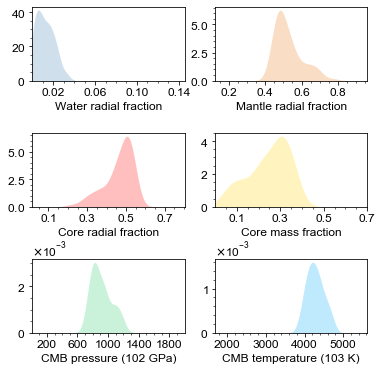

In [277]:

df_h1 = df_h[df_h['sigma_MRC']<=0.02]

inputs = ['Mass Earth_mass', 'Radius Earth_radius', 'Fe/(Si+Mg)', 'static Love number k2']
outputs = ['water radial frac', 'mantle radial frac', 'core radial frac', 'core mass frac', 'CMB press (GPa)', 'CMB temp (K)']
y_min1 = min(y_test_pre[output_parameters[0]])
y_max1 = max(y_test_pre[output_parameters[0]])
y_min2 = min(y_test_pre[output_parameters[1]])
y_max2 = max(y_test_pre[output_parameters[1]])
y_min3 = min(y_test_pre[output_parameters[2]])
y_max3 = max(y_test_pre[output_parameters[2]])
y_min4 = min(y_test_pre[output_parameters[3]])
y_max4 = max(y_test_pre[output_parameters[3]])
y_min5 = min(y_test_pre[output_parameters[4]])
y_max5 = max(y_test_pre[output_parameters[4]])
y_min6 = min(y_test_pre[output_parameters[5]])
y_max6 = max(y_test_pre[output_parameters[5]])

x_max = [
    1,
    1,
    1,
    1,
    1,
    1,
]
x_maxlabels = [
    y_min1+(y_max1-y_min1)*x_max[0],
    y_min2+(y_max2-y_min2)*x_max[1],
    y_min3+(y_max3-y_min3)*x_max[2],
    y_min4+(y_max4-y_min4)*x_max[3],
    y_min5+(y_max5-y_min5)*x_max[4],
    y_min6+(y_max6-y_min6)*x_max[5],
]

wrf = []  # H2O_radial_frac
mrf = []  # Mantle_radial_frac
crf = []  # Core_radial_frac
cmf = []  # Core mass frac
pcmb = []  # CMB temperature
tcmb = []  # CMB pressure


for x1 in np.arange(0.02,0.15,0.04):
    wrf.append((x1-y_min1)/(x_maxlabels[0]-y_min1)*x_max[0])
for x2 in np.arange(0.2,1,0.2):
    mrf.append((x2-y_min2)/(x_maxlabels[1]-y_min2)*x_max[1])
for x3 in np.arange(0.1,0.9,0.2):
    crf.append((x3-y_min3)/(x_maxlabels[2]-y_min3)*x_max[2])
for x4 in np.arange(0.1,0.8,0.2):
    cmf.append((x4-y_min4)/(x_maxlabels[3]-y_min4)*x_max[3])
for x5 in np.arange(200, 2000, 400):
    pcmb.append((x5-y_min5)/(x_maxlabels[4]-y_min5)*x_max[4])
for x6 in np.arange(2000, 6000, 1000):
    tcmb.append((x6-y_min6)/(x_maxlabels[5]-y_min6)*x_max[5])
    
xticklabels = [[round(x,2) for x in np.arange(0.02,0.15,0.04)],
               [round(x,2) for x in np.arange(0.2,1,0.2)],
               [round(x,2) for x in np.arange(0.1,0.9,0.2)],
               [round(x,2) for x in np.arange(0.1,0.8,0.2)],
               [round(x,2) for x in np.arange(200, 2000, 400)],
               [round(x,2) for x in np.arange(2000, 6000, 1000)],
              ]
xticks = [wrf, mrf, crf, cmf, pcmb, tcmb]
fig = plt.figure(figsize=(6,6))

fig.subplots_adjust(hspace=0.7, wspace=0.2)

x_max = [
    y_min1+(y_max1-y_min1)*1,
    y_min2+(y_max2-y_min2)*1,
    y_min3+(y_max3-y_min3)*1,
    y_min4+(y_max4-y_min4)*1,
    y_min5+(y_max5-y_min5)*1,
    y_min6+(y_max6-y_min6)*1,
]
for f in range(0,6):
    ax = fig.add_subplot(3, 2, f+1)
    y_min = locals()['y_min'+str(f+1)]
    y_max = locals()['y_max'+str(f+1)]
    print(y_max)
    sns.kdeplot(df_h1[outputs[f]], color=colors[f],fill=True,linewidth=0,bw_adjust=1,)
    ax.set_xlim(y_min, y_max)
    ax.set_ylim(bottom=0)
    
#     print(xticks[i])
#     xticklabels[i]

    ax.set_xticks(xticklabels[f])
#     ax.set_xticklabels(xticklabels[f])
    ax.set_xlabel(predict_label[f])
    ax.set_ylabel(None)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    formatter = tck.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-3,2))
    ax.yaxis.set_major_formatter(formatter)
#     ax.ticklabel_format(
#         style='sci',
#         scilimits=(-3,2),
#         axis='y')
# plt.tight_layout()
plt.savefig('MRC_phy_pred_HD3167b_20220925.pdf')

# MRk2

In [81]:
input_parameters = [
    'Mass', 
    'Radius',
    'k_2',
]

output_parameters = [
    'H2O_radial_frac',
    'Mantle_radial_frac',
    'Core_radial_frac',
    'Core_mass_frac',
    'P_CMB', 
    'T_CMB',
]
# load trained model and scaler
OUTPUT_DIMS = len(output_parameters)
N_MIXES = 20
model = load_model(
    "MDN_MRk2_0810.h5", 
    custom_objects={"MDN": mdn.MDN(OUTPUT_DIMS, N_MIXES), "mdn_loss_func": mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES)},
    compile=False
)
input_scaler = joblib.load("MDN_MRk2_Xscaler_0810.save")
output_scaler = joblib.load("MDN_MRk2_yscaler_0810.save")

df_all = pd.read_csv('Rocky_compostion.txt', sep='\t')
X = df_all[input_parameters]
y = df_all.loc[:, output_parameters]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
a, X_test_pre, b, y_test_pre = train_test_split(X_test, y_test, test_size=0.2)

## Predict Kepler-78b

### MDN model

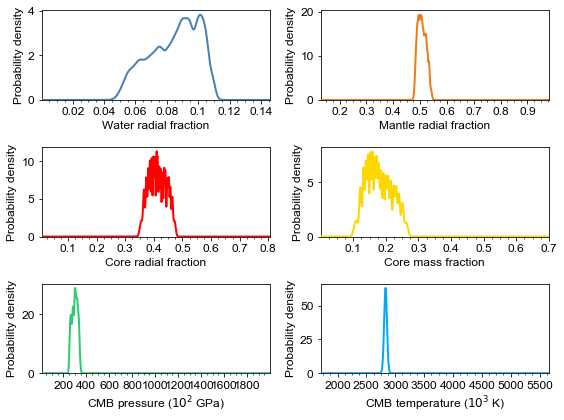

In [82]:
# input mass and radius for predicting must be earth units
input_array = np.array(
    [
        [1.77],  # mass
        [1.228],  # radius
#         [0.685],  # bulk Fe/(Mg+Si)
        [0.819],  # k2
    ]
)
scaled_input = input_scaler.transform(input_array.T)

pred = model.predict(scaled_input)

# split up the mixture parameters
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)

for m in range(OUTPUT_DIMS):
    locals()['mus'+str(m)] = []
    locals()['sigs'+str(m)] = []
#     print(m)
    for n in range(20):
#         print(n)
        locals()['mus'+str(m)].append(mus[0][n*OUTPUT_DIMS + m])
        locals()['sigs'+str(m)].append(sigs[0][n*OUTPUT_DIMS + m])

y_min1 = min(y_test_pre[output_parameters[0]])
y_max1 = max(y_test_pre[output_parameters[0]])
y_min2 = min(y_test_pre[output_parameters[1]])
y_max2 = max(y_test_pre[output_parameters[1]])
y_min3 = min(y_test_pre[output_parameters[2]])
y_max3 = max(y_test_pre[output_parameters[2]])
y_min4 = min(y_test_pre[output_parameters[3]])
y_max4 = max(y_test_pre[output_parameters[3]])
y_min5 = min(y_test_pre[output_parameters[4]])
y_max5 = max(y_test_pre[output_parameters[4]])
y_min6 = min(y_test_pre[output_parameters[5]])
y_max6 = max(y_test_pre[output_parameters[5]])

x_max = [
    1,
    1,
    1,
    1,
    1,
    1,
]
x_maxlabels = [
    y_min1+(y_max1-y_min1)*x_max[0],
    y_min2+(y_max2-y_min2)*x_max[1],
    y_min3+(y_max3-y_min3)*x_max[2],
    y_min4+(y_max4-y_min4)*x_max[3],
    y_min5+(y_max5-y_min5)*x_max[4],
    y_min6+(y_max6-y_min6)*x_max[5],
]

wrf = []  # H2O_radial_frac
mrf = []  # Mantle_radial_frac
crf = []  # Core_radial_frac
cmf = []  # Core mass frac
pcmb = []  # CMB temperature
tcmb = []  # CMB pressure


for x1 in np.arange(0.02,0.15,0.02):
    wrf.append((x1-y_min1)/(x_maxlabels[0]-y_min1)*x_max[0])
for x2 in np.arange(0.2,1,0.1):
    mrf.append((x2-y_min2)/(x_maxlabels[1]-y_min2)*x_max[1])
for x3 in np.arange(0.1,0.9,0.1):
    crf.append((x3-y_min3)/(x_maxlabels[2]-y_min3)*x_max[2])
for x4 in np.arange(0.1,0.8,0.1):
    cmf.append((x4-y_min4)/(x_maxlabels[3]-y_min4)*x_max[3])
for x5 in np.arange(200, 2000, 200):
    pcmb.append((x5-y_min5)/(x_maxlabels[4]-y_min5)*x_max[4])
for x6 in np.arange(2000, 6000, 500):
    tcmb.append((x6-y_min6)/(x_maxlabels[5]-y_min6)*x_max[5])
    
xticklabels = [[round(x,2) for x in np.arange(0.02,0.15,0.02)],
               [round(x,2) for x in np.arange(0.2,1,0.1)],
               [round(x,2) for x in np.arange(0.1,0.9,0.1)],
               [round(x,2) for x in np.arange(0.1,0.8,0.1)],
               [round(x,2) for x in np.arange(200, 2000, 200)],
               [round(x,2) for x in np.arange(2000, 6000, 500)],
              ]
xticks = [wrf, mrf, crf, cmf, pcmb, tcmb]

colors = [
    "steelblue",
    "#EA7D1A",
    "red", 
    "gold", 
    "#2ecc71",
    "#03a9f4"
]
predict_label = [
    "Water radial fraction", 
    "Mantle radial fraction",
    "Core radial fraction", 
    "Core mass fraction", 
    "CMB pressure ($10^2$ GPa)", 
    "CMB temperature ($10^3$ K)"
]


y_label = np.arange(0,1,0.001).reshape(-1,1)
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(hspace=0.3, wspace=0.1)
for i in range(OUTPUT_DIMS):
    ax = fig.add_subplot(3, 2, i+1)
    # y_label = y_labels[:, i].reshape(-1,1)
    # for i, label in zip(range(OUTPUT_DIMS), predict_label):
#     fig, ax = plt.subplots(figsize=(8,4))
    # label = "Water radial fraction"
    ###################Earth###########################
    mus_ = np.array(locals()['mus'+str(i)])
    sigs_ = np.array(locals()['sigs'+str(i)])
    factors = 1 / math.sqrt(2*math.pi) / sigs_
    exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
    GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
    plt.plot(
        y_label, 
        GMM_PDF,
        color=colors[i],
#         label=label,
        lw=2,
        zorder=10,
    )
    ax.set_xlim(0, x_max[i])
    ax.set_ylim(bottom=0)
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
#     print(xticks[i])
#     xticklabels[i]
    ax.set_xticks(xticks[i])
    ax.set_xticklabels(xticklabels[i])
    ax.set_xlabel(predict_label[i])
    ax.set_ylabel("Probability density")
plt.tight_layout()
plt.savefig('MRk2_mdn_pred_Kepler-78b_20220925.pdf')

### Physical model

0.145835
0.980009765
0.806029
0.699993
1999.81
5663.58


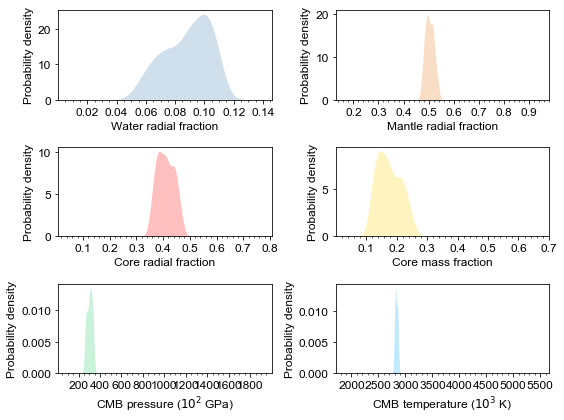

In [86]:
df_k = pd.read_csv('Kepler 78b.txt', sep='\t')
df_k.drop(columns=df_k.columns[0], inplace=True)  # delete useless column 0

df_k1 = df_k[df_k['sigma_MRk2']<=0.015]

inputs = ['Mass Earth_mass', 'Radius Earth_radius', 'Fe/(Si+Mg)', 'static Love number k2']
outputs = ['water radial frac', 'mantle radial frac', 'core radial frac', 'core mass frac', 'CMB press (GPa)', 'CMB temp (K)']
y_min1 = min(y_test_pre[output_parameters[0]])
y_max1 = max(y_test_pre[output_parameters[0]])
y_min2 = min(y_test_pre[output_parameters[1]])
y_max2 = max(y_test_pre[output_parameters[1]])
y_min3 = min(y_test_pre[output_parameters[2]])
y_max3 = max(y_test_pre[output_parameters[2]])
y_min4 = min(y_test_pre[output_parameters[3]])
y_max4 = max(y_test_pre[output_parameters[3]])
y_min5 = min(y_test_pre[output_parameters[4]])
y_max5 = max(y_test_pre[output_parameters[4]])
y_min6 = min(y_test_pre[output_parameters[5]])
y_max6 = max(y_test_pre[output_parameters[5]])

x_max = [
    1,
    1,
    1,
    1,
    1,
    1,
]
x_maxlabels = [
    y_min1+(y_max1-y_min1)*x_max[0],
    y_min2+(y_max2-y_min2)*x_max[1],
    y_min3+(y_max3-y_min3)*x_max[2],
    y_min4+(y_max4-y_min4)*x_max[3],
    y_min5+(y_max5-y_min5)*x_max[4],
    y_min6+(y_max6-y_min6)*x_max[5],
]

wrf = []  # H2O_radial_frac
mrf = []  # Mantle_radial_frac
crf = []  # Core_radial_frac
cmf = []  # Core mass frac
pcmb = []  # CMB temperature
tcmb = []  # CMB pressure


for x1 in np.arange(0.02,0.15,0.02):
    wrf.append((x1-y_min1)/(x_maxlabels[0]-y_min1)*x_max[0])
for x2 in np.arange(0.2,1,0.1):
    mrf.append((x2-y_min2)/(x_maxlabels[1]-y_min2)*x_max[1])
for x3 in np.arange(0.1,0.9,0.1):
    crf.append((x3-y_min3)/(x_maxlabels[2]-y_min3)*x_max[2])
for x4 in np.arange(0.1,0.8,0.1):
    cmf.append((x4-y_min4)/(x_maxlabels[3]-y_min4)*x_max[3])
for x5 in np.arange(200, 2000, 200):
    pcmb.append((x5-y_min5)/(x_maxlabels[4]-y_min5)*x_max[4])
for x6 in np.arange(2000, 6000, 500):
    tcmb.append((x6-y_min6)/(x_maxlabels[5]-y_min6)*x_max[5])
    
xticklabels = [[round(x,2) for x in np.arange(0.02,0.15,0.02)],
               [round(x,2) for x in np.arange(0.2,1,0.1)],
               [round(x,2) for x in np.arange(0.1,0.9,0.1)],
               [round(x,2) for x in np.arange(0.1,0.8,0.1)],
               [round(x,2) for x in np.arange(200, 2000, 200)],
               [round(x,2) for x in np.arange(2000, 6000, 500)],
              ]
xticks = [wrf, mrf, crf, cmf, pcmb, tcmb]
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(hspace=0.3, wspace=0.1)



x_max = [
    y_min1+(y_max1-y_min1)*1,
    y_min2+(y_max2-y_min2)*1,
    y_min3+(y_max3-y_min3)*1,
    y_min4+(y_max4-y_min4)*1,
    y_min5+(y_max5-y_min5)*1,
    y_min6+(y_max6-y_min6)*1,
]
for f in range(0,6):
    ax = fig.add_subplot(3, 2, f+1)
    y_min = locals()['y_min'+str(f+1)]
    y_max = locals()['y_max'+str(f+1)]
    print(y_max)
    sns.kdeplot(df_k1[outputs[f]], color=colors[f],fill=True,linewidth=0,bw_adjust=1,)
    ax.set_xlim(y_min, y_max)
    ax.set_ylim(bottom=0)
    
#     print(xticks[i])
#     xticklabels[i]

    ax.set_xticks(xticklabels[f])
#     ax.set_xticklabels(xticklabels[f])
    ax.set_xlabel(predict_label[f])
    ax.set_ylabel("Probability density")
    ax.xaxis.set_minor_locator(AutoMinorLocator())
plt.tight_layout()
plt.savefig('MRk2_phy_pred_Kepler-78b_20220925.pdf')

## Predict HD3167b

### MDN model

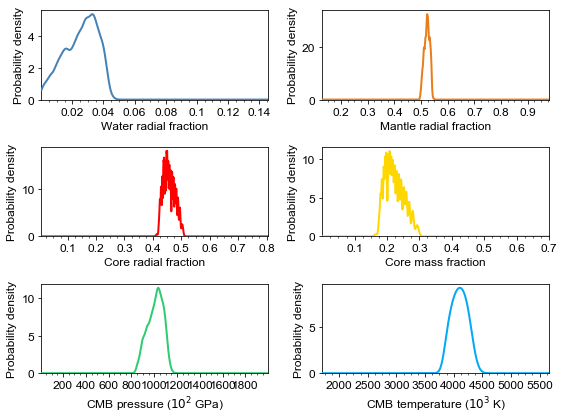

In [87]:
# input mass and radius for predicting must be earth units
input_array2 = np.array(
    [
        [5.69],  # mass
        [1.574],  # radius
#         [0.630],  # bulk Fe/(Mg+Si)
        [0.854],  # k2
    ]
)
scaled_input2 = input_scaler.transform(input_array2.T)

pred2 = model.predict(scaled_input2)


# split up the mixture parameters
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred2)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred2)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred2)

for m in range(OUTPUT_DIMS):
    locals()['mus'+str(m)] = []
    locals()['sigs'+str(m)] = []
#     print(m)
    for n in range(20):
#         print(n)
        locals()['mus'+str(m)].append(mus[0][n*OUTPUT_DIMS + m])
        locals()['sigs'+str(m)].append(sigs[0][n*OUTPUT_DIMS + m])

y_min1 = min(y_test_pre[output_parameters[0]])
y_max1 = max(y_test_pre[output_parameters[0]])
y_min2 = min(y_test_pre[output_parameters[1]])
y_max2 = max(y_test_pre[output_parameters[1]])
y_min3 = min(y_test_pre[output_parameters[2]])
y_max3 = max(y_test_pre[output_parameters[2]])
y_min4 = min(y_test_pre[output_parameters[3]])
y_max4 = max(y_test_pre[output_parameters[3]])
y_min5 = min(y_test_pre[output_parameters[4]])
y_max5 = max(y_test_pre[output_parameters[4]])
y_min6 = min(y_test_pre[output_parameters[5]])
y_max6 = max(y_test_pre[output_parameters[5]])

x_max = [
    1,
    1,
    1,
    1,
    1,
    1,
]
x_maxlabels = [
    y_min1+(y_max1-y_min1)*x_max[0],
    y_min2+(y_max2-y_min2)*x_max[1],
    y_min3+(y_max3-y_min3)*x_max[2],
    y_min4+(y_max4-y_min4)*x_max[3],
    y_min5+(y_max5-y_min5)*x_max[4],
    y_min6+(y_max6-y_min6)*x_max[5],
]

wrf = []  # H2O_radial_frac
mrf = []  # Mantle_radial_frac
crf = []  # Core_radial_frac
cmf = []  # Core mass frac
pcmb = []  # CMB temperature
tcmb = []  # CMB pressure


for x1 in np.arange(0.02,0.15,0.02):
    wrf.append((x1-y_min1)/(x_maxlabels[0]-y_min1)*x_max[0])
for x2 in np.arange(0.2,1,0.1):
    mrf.append((x2-y_min2)/(x_maxlabels[1]-y_min2)*x_max[1])
for x3 in np.arange(0.1,0.9,0.1):
    crf.append((x3-y_min3)/(x_maxlabels[2]-y_min3)*x_max[2])
for x4 in np.arange(0.1,0.8,0.1):
    cmf.append((x4-y_min4)/(x_maxlabels[3]-y_min4)*x_max[3])
for x5 in np.arange(200, 2000, 200):
    pcmb.append((x5-y_min5)/(x_maxlabels[4]-y_min5)*x_max[4])
for x6 in np.arange(2000, 6000, 500):
    tcmb.append((x6-y_min6)/(x_maxlabels[5]-y_min6)*x_max[5])
    
xticklabels = [[round(x,2) for x in np.arange(0.02,0.15,0.02)],
               [round(x,2) for x in np.arange(0.2,1,0.1)],
               [round(x,2) for x in np.arange(0.1,0.9,0.1)],
               [round(x,2) for x in np.arange(0.1,0.8,0.1)],
               [round(x,2) for x in np.arange(200, 2000, 200)],
               [round(x,2) for x in np.arange(2000, 6000, 500)],
              ]
xticks = [wrf, mrf, crf, cmf, pcmb, tcmb]

colors = [
    "steelblue",
    "#EA7D1A",
    "red", 
    "gold", 
    "#2ecc71",
    "#03a9f4"
]
pred2ict_label = [
    "Water radial fraction", 
    "Mantle radial fraction",
    "Core radial fraction", 
    "Core mass fraction", 
    "CMB pressure ($10^2$ GPa)", 
    "CMB temperature ($10^3$ K)"
]


y_label = np.arange(0,1,0.001).reshape(-1,1)
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(hspace=0.3, wspace=0.1)
for i in range(OUTPUT_DIMS):
    ax = fig.add_subplot(3, 2, i+1)
    # y_label = y_labels[:, i].reshape(-1,1)
    # for i, label in zip(range(OUTPUT_DIMS), pred2ict_label):
#     fig, ax = plt.subplots(figsize=(8,4))
    # label = "Water radial fraction"
    ###################Earth###########################
    mus_ = np.array(locals()['mus'+str(i)])
    sigs_ = np.array(locals()['sigs'+str(i)])
    factors = 1 / math.sqrt(2*math.pi) / sigs_
    exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
    GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
    plt.plot(
        y_label, 
        GMM_PDF,
        color=colors[i],
#         label=label,
        lw=2,
        zorder=10,
    )
    ax.set_xlim(0, x_max[i])
    ax.set_ylim(bottom=0)
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
#     print(xticks[i])
#     xticklabels[i]
    ax.set_xticks(xticks[i])
    ax.set_xticklabels(xticklabels[i])
    ax.set_xlabel(pred2ict_label[i])
    ax.set_ylabel("Probability density")
plt.tight_layout()
plt.savefig('MRk2_mdn_pred_HD3167b_20220925.pdf')

### Physical model

0.145835
0.980009765
0.806029
0.699993
1999.81
5663.58


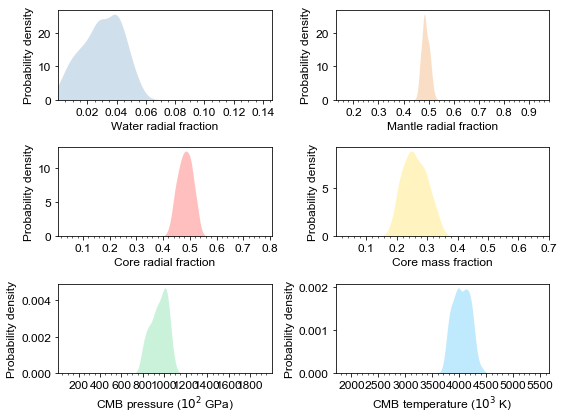

In [88]:

df_h1 = df_h[df_h['sigma_MRk2']<=0.015]

inputs = ['Mass Earth_mass', 'Radius Earth_radius', 'Fe/(Si+Mg)', 'static Love number k2']
outputs = ['water radial frac', 'mantle radial frac', 'core radial frac', 'core mass frac', 'CMB press (GPa)', 'CMB temp (K)']
y_min1 = min(y_test_pre[output_parameters[0]])
y_max1 = max(y_test_pre[output_parameters[0]])
y_min2 = min(y_test_pre[output_parameters[1]])
y_max2 = max(y_test_pre[output_parameters[1]])
y_min3 = min(y_test_pre[output_parameters[2]])
y_max3 = max(y_test_pre[output_parameters[2]])
y_min4 = min(y_test_pre[output_parameters[3]])
y_max4 = max(y_test_pre[output_parameters[3]])
y_min5 = min(y_test_pre[output_parameters[4]])
y_max5 = max(y_test_pre[output_parameters[4]])
y_min6 = min(y_test_pre[output_parameters[5]])
y_max6 = max(y_test_pre[output_parameters[5]])

x_max = [
    1,
    1,
    1,
    1,
    1,
    1,
]
x_maxlabels = [
    y_min1+(y_max1-y_min1)*x_max[0],
    y_min2+(y_max2-y_min2)*x_max[1],
    y_min3+(y_max3-y_min3)*x_max[2],
    y_min4+(y_max4-y_min4)*x_max[3],
    y_min5+(y_max5-y_min5)*x_max[4],
    y_min6+(y_max6-y_min6)*x_max[5],
]

wrf = []  # H2O_radial_frac
mrf = []  # Mantle_radial_frac
crf = []  # Core_radial_frac
cmf = []  # Core mass frac
pcmb = []  # CMB temperature
tcmb = []  # CMB pressure


for x1 in np.arange(0.02,0.15,0.02):
    wrf.append((x1-y_min1)/(x_maxlabels[0]-y_min1)*x_max[0])
for x2 in np.arange(0.2,1,0.1):
    mrf.append((x2-y_min2)/(x_maxlabels[1]-y_min2)*x_max[1])
for x3 in np.arange(0.1,0.9,0.1):
    crf.append((x3-y_min3)/(x_maxlabels[2]-y_min3)*x_max[2])
for x4 in np.arange(0.1,0.8,0.1):
    cmf.append((x4-y_min4)/(x_maxlabels[3]-y_min4)*x_max[3])
for x5 in np.arange(200, 2000, 200):
    pcmb.append((x5-y_min5)/(x_maxlabels[4]-y_min5)*x_max[4])
for x6 in np.arange(2000, 6000, 500):
    tcmb.append((x6-y_min6)/(x_maxlabels[5]-y_min6)*x_max[5])
    
xticklabels = [[round(x,2) for x in np.arange(0.02,0.15,0.02)],
               [round(x,2) for x in np.arange(0.2,1,0.1)],
               [round(x,2) for x in np.arange(0.1,0.9,0.1)],
               [round(x,2) for x in np.arange(0.1,0.8,0.1)],
               [round(x,2) for x in np.arange(200, 2000, 200)],
               [round(x,2) for x in np.arange(2000, 6000, 500)],
              ]
xticks = [wrf, mrf, crf, cmf, pcmb, tcmb]
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(hspace=0.3, wspace=0.1)



x_max = [
    y_min1+(y_max1-y_min1)*1,
    y_min2+(y_max2-y_min2)*1,
    y_min3+(y_max3-y_min3)*1,
    y_min4+(y_max4-y_min4)*1,
    y_min5+(y_max5-y_min5)*1,
    y_min6+(y_max6-y_min6)*1,
]
for f in range(0,6):
    ax = fig.add_subplot(3, 2, f+1)
    y_min = locals()['y_min'+str(f+1)]
    y_max = locals()['y_max'+str(f+1)]
    print(y_max)
    sns.kdeplot(df_h1[outputs[f]], color=colors[f],fill=True,linewidth=0,bw_adjust=1,)
    ax.set_xlim(y_min, y_max)
    ax.set_ylim(bottom=0)
    
#     print(xticks[i])
#     xticklabels[i]

    ax.set_xticks(xticklabels[f])
#     ax.set_xticklabels(xticklabels[f])
    ax.set_xlabel(predict_label[f])
    ax.set_ylabel("Probability density")
    ax.xaxis.set_minor_locator(AutoMinorLocator())
plt.tight_layout()
plt.savefig('MRk2_phy_pred_HD3167b_20220925.pdf')